# Transfer Learning with TensorFlow Part 3: Scaling up

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
!nvidia-smi

Mon May 30 04:13:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2022-05-30 04:13:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-30 04:13:19 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-05-30 04:13:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   240MB/s    in 6.7s    

2022-05-30 04:13:29 (232 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classe

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning on 10% of 101 food classes


* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # It will only save the model weights which achieves the highest val_accuracy (it depends on what you monitor)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

The one above is a transfer learning feature extraction model

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 94s 321ms/step - loss: 3.4901 - accuracy: 0.2459 - val_loss: 2.6205 - val_accuracy: 0.4293
Epoch 2/5
237/237 [==============================] - 59s 249ms/step - loss: 2.3630 - accuracy: 0.4569 - val_loss: 2.1864 - val_accuracy: 0.4770
Epoch 3/5
237/237 [==============================] - 57s 239ms/step - loss: 1.9890 - accuracy: 0.5266 - val_loss: 2.0434 - val_accuracy: 0.4921
Epoch 4/5
237/237 [==============================] - 48s 203ms/step - loss: 1.7594 - accuracy: 0.5675 - val_loss: 1.9309 - val_accuracy: 0.5098
Epoch 5/5
237/237 [==============================] - 48s 201ms/step - loss: 1.6124 - accuracy: 0.6036 - val_loss: 1.9032 - val_accuracy: 0.5103


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 72ms/step - loss: 1.7092 - accuracy: 0.5554


[1.7091699838638306, 0.5554455518722534]

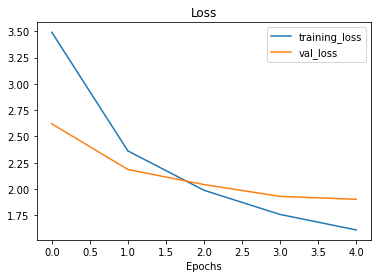

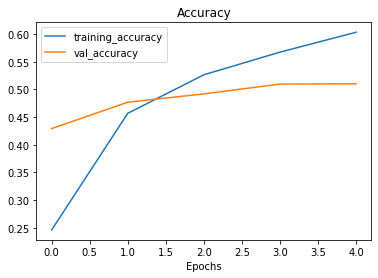

In [13]:
plot_loss_curves(history_all_classes_10_percent)

 ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [16]:
# Checking which layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 53s 194ms/step - loss: 1.3680 - accuracy: 0.6463 - val_loss: 1.8865 - val_accuracy: 0.5064
Epoch 6/10
237/237 [==============================] - 43s 179ms/step - loss: 1.2349 - accuracy: 0.6779 - val_loss: 1.8896 - val_accuracy: 0.5106
Epoch 7/10
237/237 [==============================] - 41s 172ms/step - loss: 1.1568 - accuracy: 0.6927 - val_loss: 1.8498 - val_accuracy: 0.5204
Epoch 8/10
237/237 [==============================] - 40s 169ms/step - loss: 1.0815 - accuracy: 0.7170 - val_loss: 1.8870 - val_accuracy: 0.5114
Epoch 9/10
237/237 [==============================] - 40s 167ms/step - loss: 1.0288 - accuracy: 0.7240 - val_loss: 1.8401 - val_accuracy: 0.5273
Epoch 10/10
237/237 [==============================] - 39s 163ms/step - loss: 0.9698 - accuracy: 0.7446 - val_loss: 1.8939 - val_accuracy: 0.5114


In [19]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 56s 71ms/step - loss: 1.6057 - accuracy: 0.5798


[1.605744481086731, 0.5798019766807556]

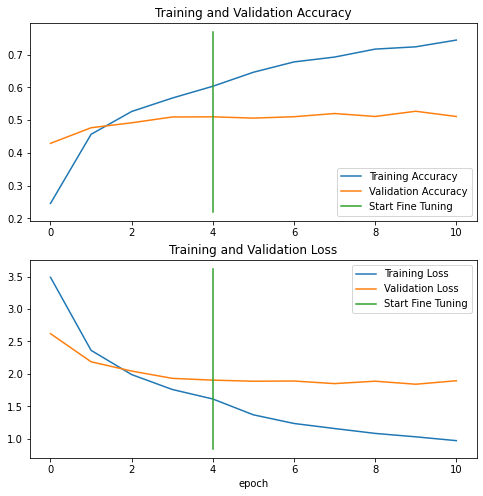

In [22]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.


In [23]:
# Save our fine-tuning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/assets


Note: Loading the model with the following cell will output a large amount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage


* Now the warnings are fixed

In [24]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [25]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 60s 74ms/step - loss: 1.6057 - accuracy: 0.5798


[1.605744481086731, 0.5798019766807556]

In [26]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.605744481086731, 0.5798019766807556]

## Evaluating the performance of the model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [27]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-05-30 04:50:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 173.194.194.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   196MB/s    in 0.2s    

2022-05-30 04:50:47 (196 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [29]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [31]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 59s 73ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]